In [1]:
# TODO use GAN?

import os, copy, torch, numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision.transforms import v2
from torchvision import transforms
import torch
import torch.nn as nn
from tqdm import tqdm 
from PIL import Image

from matplotlib import pyplot as plt

device = "cpu"

In [2]:
DATASETS = "dataset/"
EMERALD = DATASETS + "emerald/"
CONTOURS = DATASETS + "gt_emerald/"

ds = os.listdir(CONTOURS)

#np.random.shuffle(ds)
#test, val = ds[1:], ds[:1]

val = ['252.png']
test = [i for i in ds if i not in val]

test, val

(['233.png',
  '351.png',
  '219.png',
  '3.png',
  '346.png',
  '282.png',
  '319.png',
  '36.png',
  '86.png'],
 ['252.png'])

In [3]:
class SatelliteDataset(Dataset):
    def __init__(self, list):
        self.img_list = []

        for i in list:
            cont = read_image(CONTOURS + i).float().sum(dim=0)
            cont = (cont > cont.mean()).float()

            img = read_image(EMERALD + i).float() / 255.0
            alpha = img[[3]]
            img = img[[0,1,2]] * alpha
            img += 1 - alpha

            img = torch.concatenate((img, cont.unsqueeze(0)), dim=0)
            self.img_list.append(img)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        return self.img_list[idx]

# Results depend on validation set, so we fix the seed
np.random.seed(0)
torch.manual_seed(0)

train_ds = SatelliteDataset(test)
train_dl = DataLoader(train_ds, batch_size=3, shuffle=True)

val_ds = SatelliteDataset(val)
val_dl = DataLoader(val_ds, batch_size=len(val_ds), shuffle=True)

len(train_ds), len(val_ds)

(9, 1)

In [4]:
class RandomNoise(nn.Module):
    def __init__(self, std=0.1):
        super().__init__()
        self.std = std

    def forward(self, x):
        std = torch.rand(1).item() * self.std
        noise = torch.randn_like(x) * std
        return x + noise

train_transform1 = v2.Compose([
    v2.RandomCrop((60, 60)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
])

train_transform2 = v2.Compose([
    v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.5),
    v2.RandomGrayscale(p=0.2),
    v2.RandomApply([RandomNoise(std=0.04)], p = 0.5),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 60, 60]) torch.Size([3, 1, 60, 60])


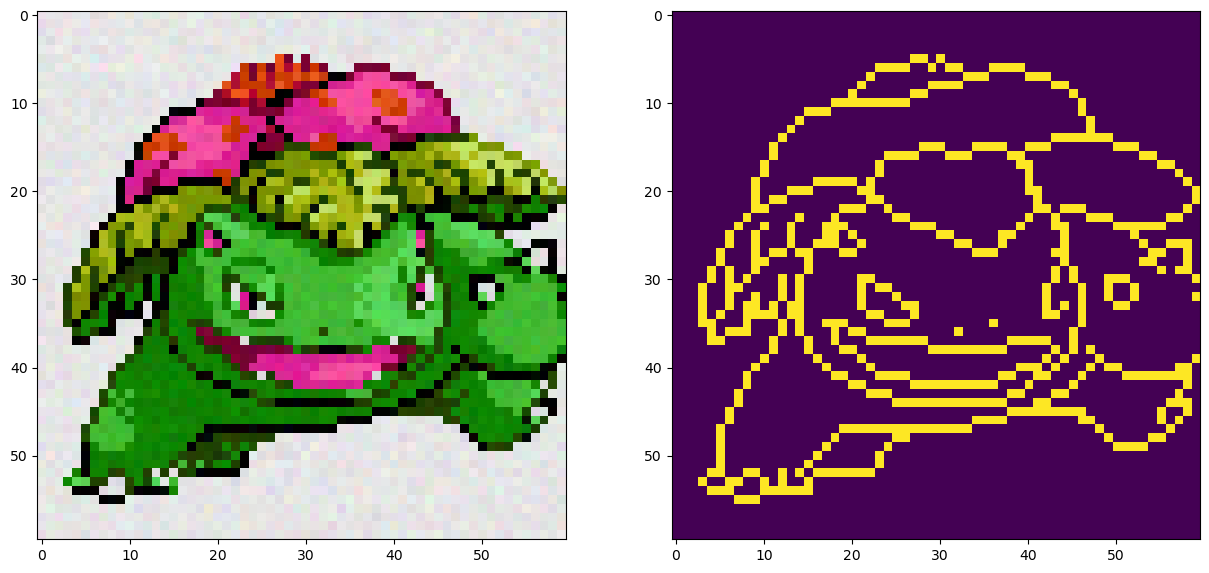

In [5]:
data = next(iter(train_dl))
data = torch.stack([train_transform1(x) for x in data])
im = data[:, :-1]
lb = data[:, [-1]]

im = torch.stack([train_transform2(x) for x in im])

print(im.shape, lb.shape)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(im[0].permute(1, 2, 0).numpy())
axes[1].imshow(lb[0].permute(1, 2, 0).numpy())
plt.show()

In [6]:
class ConvolutionBlock(nn.Module):
    def __init__(self, in_c, out_c, kernel_size, padding='same', stride=1, dilation=1, bias=True, residual=False):
        super().__init__()

        self.residual = residual

        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 
                    kernel_size=kernel_size,
                    padding=padding,
                    padding_mode='zeros',
                    stride=stride, 
                    dilation=dilation,
                    bias=bias),
            nn.BatchNorm2d(out_c),
            nn.GELU()
        )

    def forward(self, x):
        if self.residual:
            return x + self.conv(x)
        return self.conv(x)

class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc = nn.Sequential(
            ConvolutionBlock(3, 32, kernel_size=1),

            ConvolutionBlock(32, 32, kernel_size=3, bias=False, residual=True),
            nn.Dropout(0.5),
            ConvolutionBlock(32, 32, kernel_size=3, bias=False, residual=True),
            nn.Dropout(0.5),
            ConvolutionBlock(32, 32, kernel_size=3, bias=False, residual=True),
            nn.Dropout(0.5),
            
            nn.Conv2d(32, 1, kernel_size=1),
            nn.BatchNorm2d(1),
        )

    def forward(self, x):
        x = self.enc(x)

        if not self.training:
            x *= 100000

        return torch.sigmoid(x)

model = Network().to(device)

In [7]:
#https://www.mdpi.com/2072-4292/11/9/1015/pdf
#@torch.compile
def ssim_loss(pred, target):
    mean_pred = torch.mean(pred, dim=(1, 2, 3))
    mean_target = torch.mean(target, dim=(1, 2, 3))

    var_pred = torch.var(pred, dim=(1, 2, 3))
    var_target = torch.var(target, dim=(1, 2, 3))

    cov = torch.mean(pred * target, dim=(1, 2, 3)) - mean_pred * mean_target

    c1 = 0.01 ** 2
    c2 = 0.03 ** 2

    ssim = (2 * mean_pred * mean_target + c1) * (2 * cov + c2) 
    ssim /= (mean_pred ** 2 + mean_target ** 2 + c1) * (var_pred + var_target + c2)

    return (1 - ssim) / 2

Epoch 0. Loss: 1.5105: 100%|██████████| 10/10 [00:01<00:00,  9.63it/s]


2.75038 *


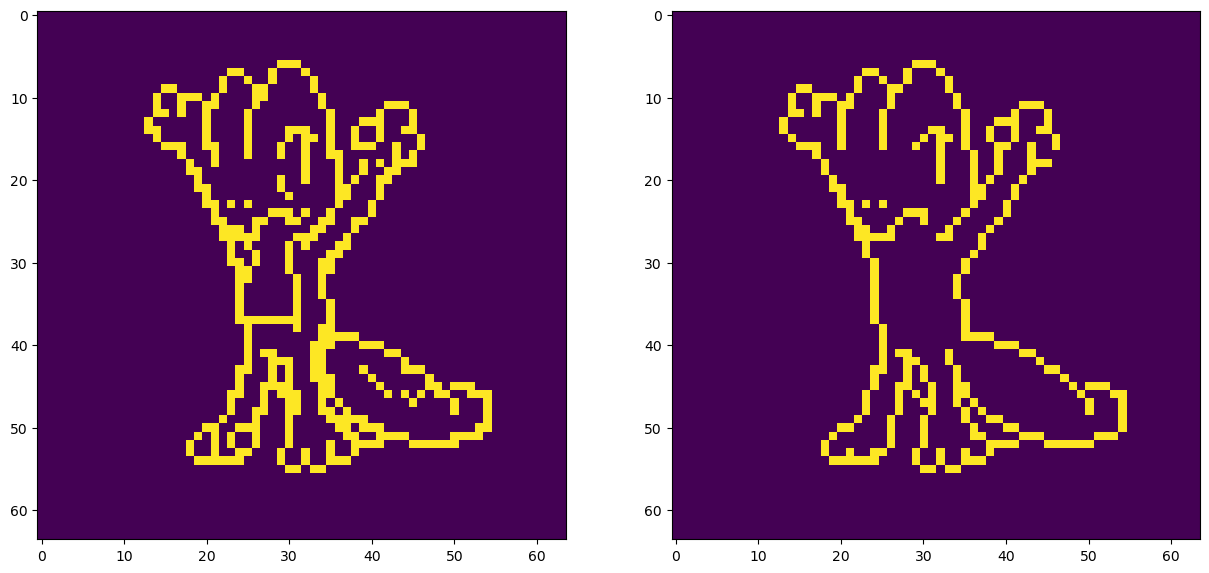

Epoch 1. Loss: 1.5277: 100%|██████████| 10/10 [00:00<00:00, 10.42it/s]


2.39521 *


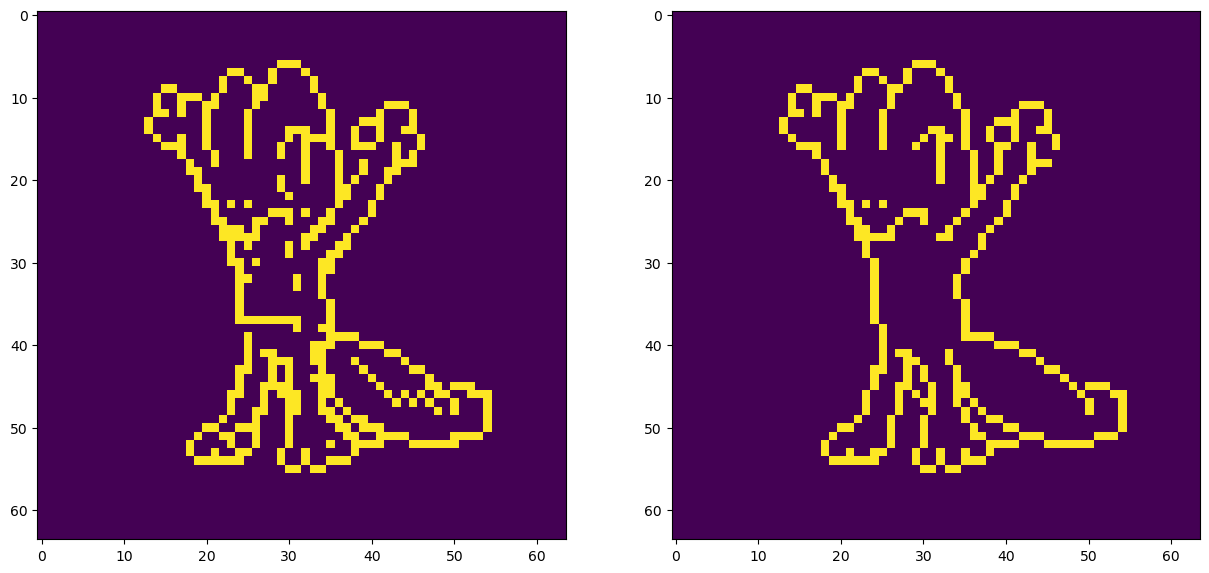

Epoch 2. Loss: 1.2614: 100%|██████████| 10/10 [00:01<00:00,  8.51it/s]


2.31201 *


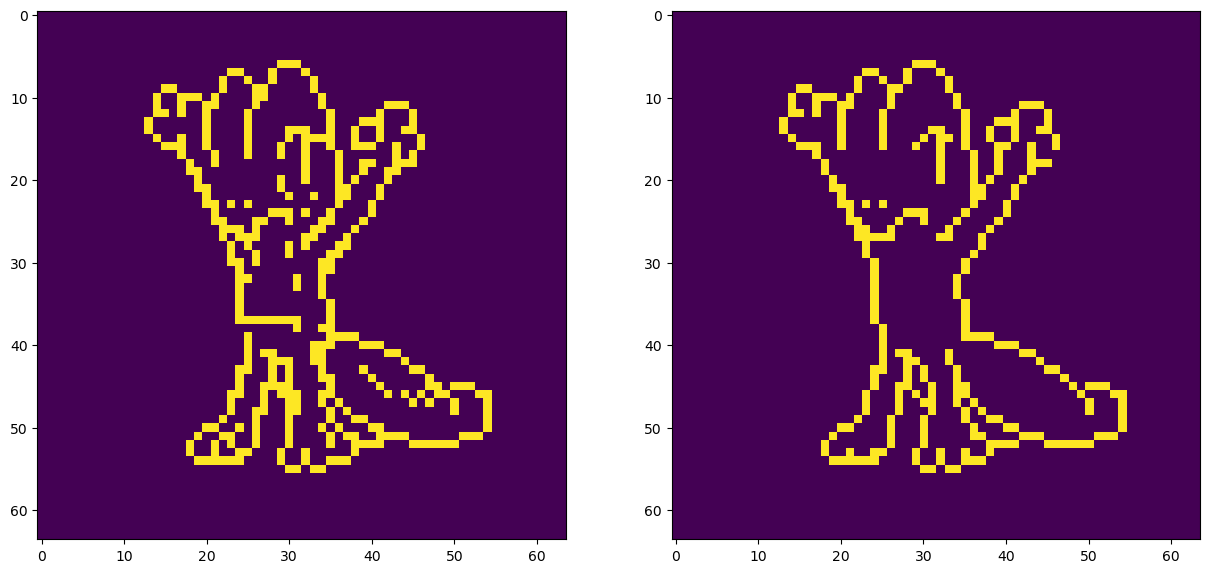

Epoch 3. Loss: 1.2284: 100%|██████████| 10/10 [00:01<00:00,  9.12it/s]


1.63327 *


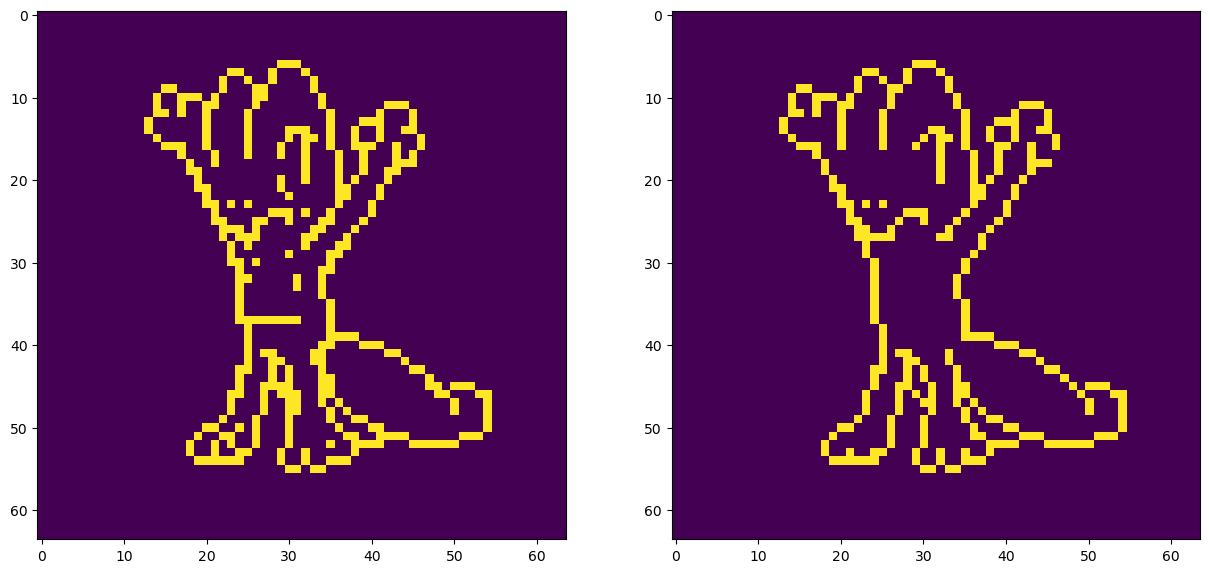

Epoch 4. Loss: 0.9832: 100%|██████████| 10/10 [00:00<00:00, 10.02it/s]


0.86861 *


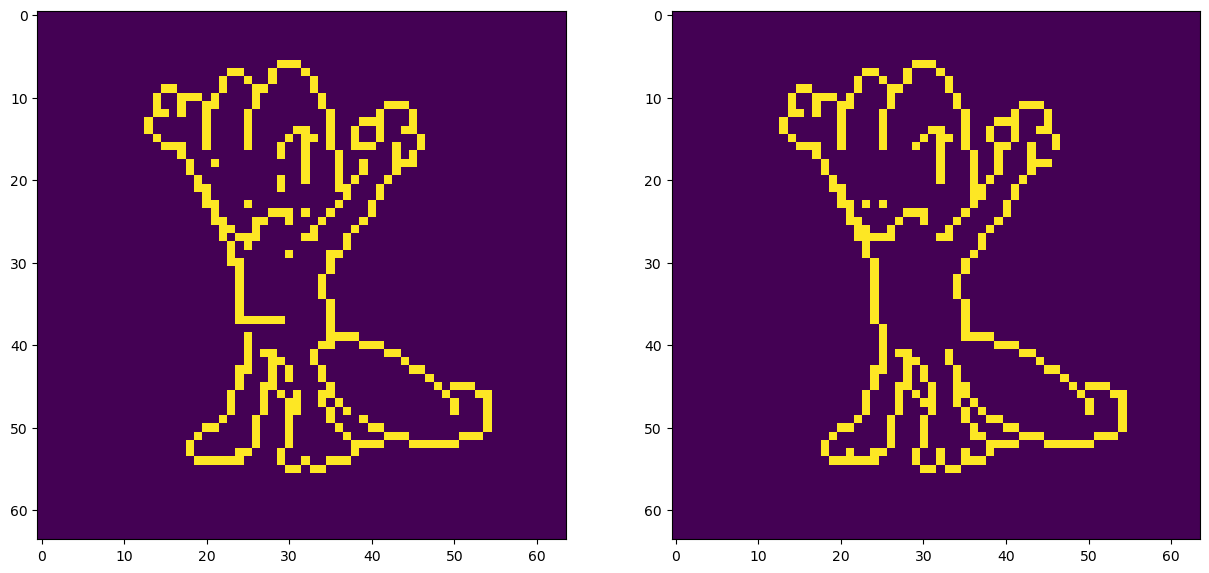

Epoch 5. Loss: 0.9063: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


0.84151 *


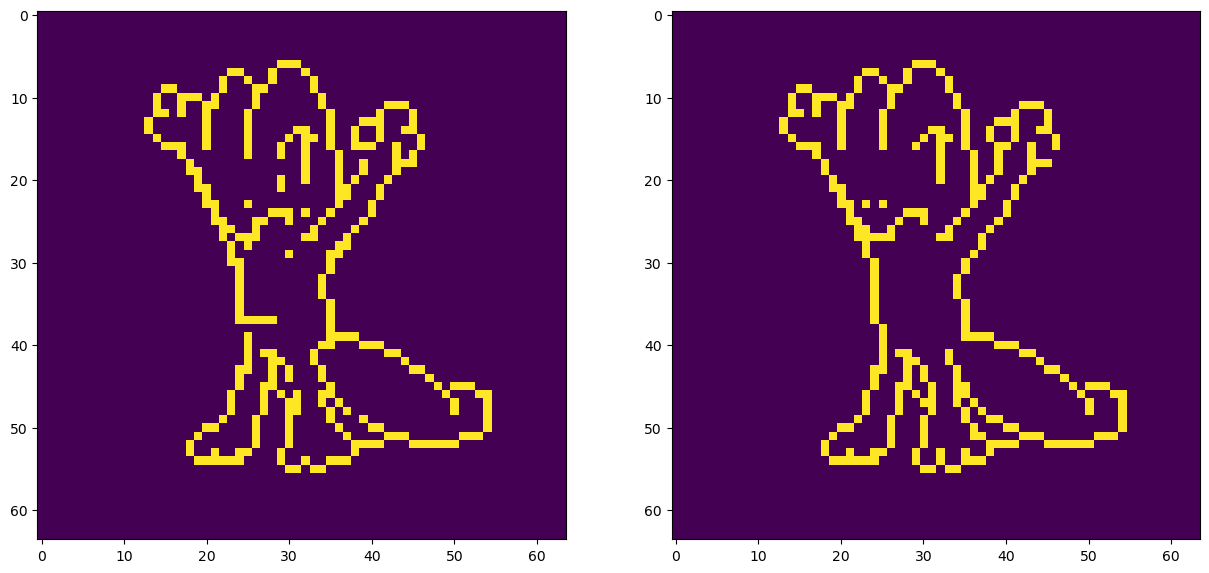

Epoch 6. Loss: 0.9540: 100%|██████████| 10/10 [00:00<00:00, 10.76it/s]


0.84151 *


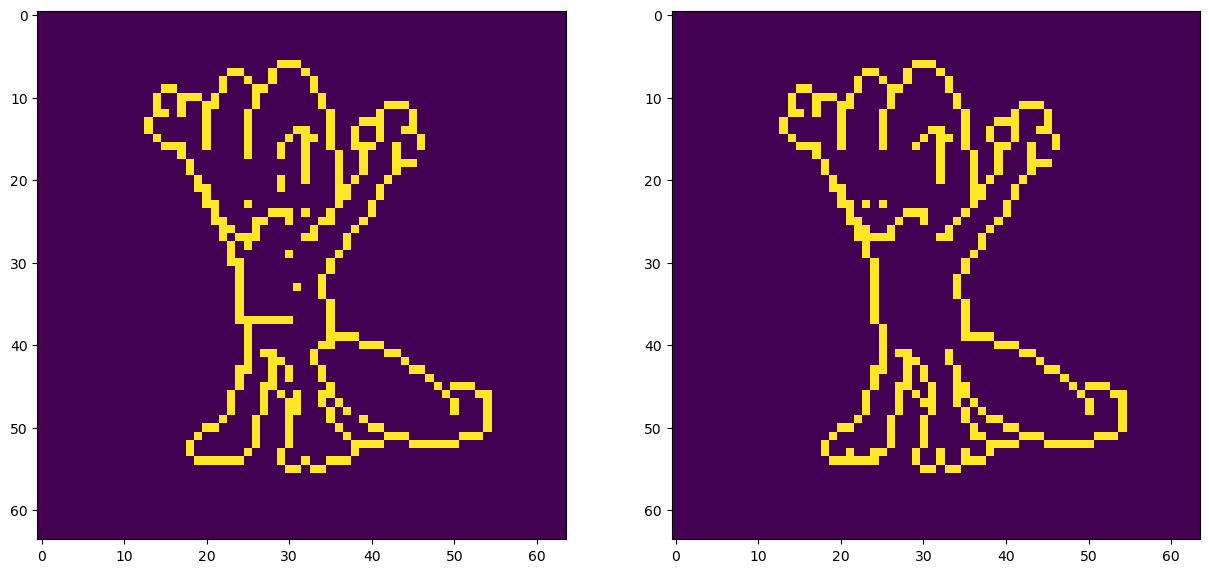

Epoch 7. Loss: 0.6774: 100%|██████████| 10/10 [00:01<00:00,  9.65it/s]


1.16881


Epoch 8. Loss: 0.5842: 100%|██████████| 10/10 [00:01<00:00,  9.92it/s]


0.81437 *


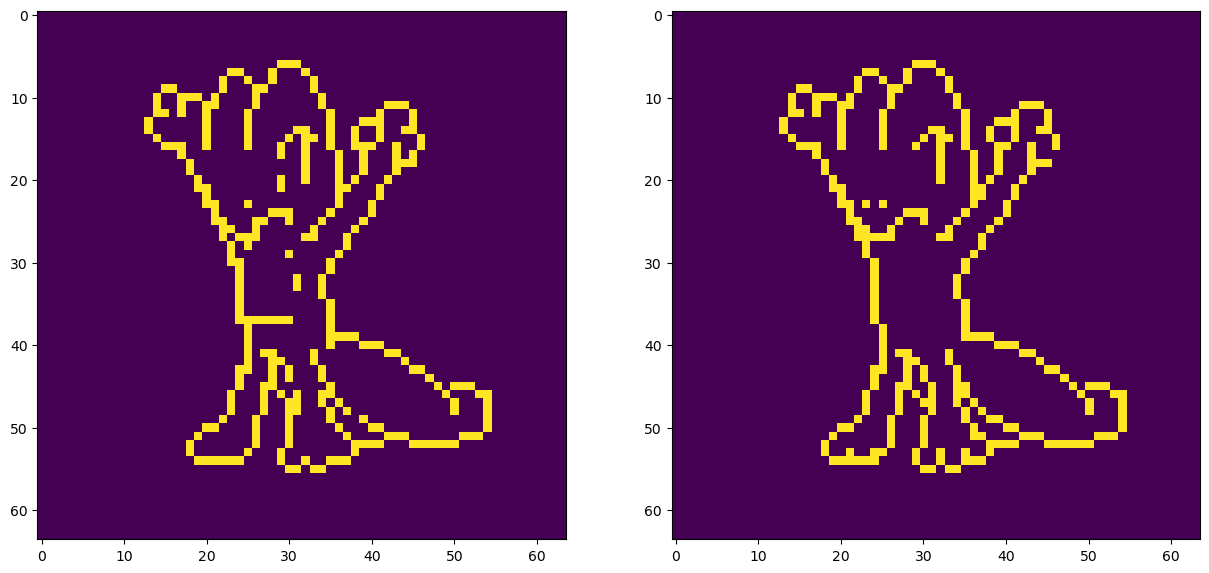

Epoch 9. Loss: 0.5547: 100%|██████████| 10/10 [00:01<00:00,  8.97it/s]


1.16839


Epoch 10. Loss: 0.6031: 100%|██████████| 10/10 [00:01<00:00,  9.96it/s]


0.76026 *


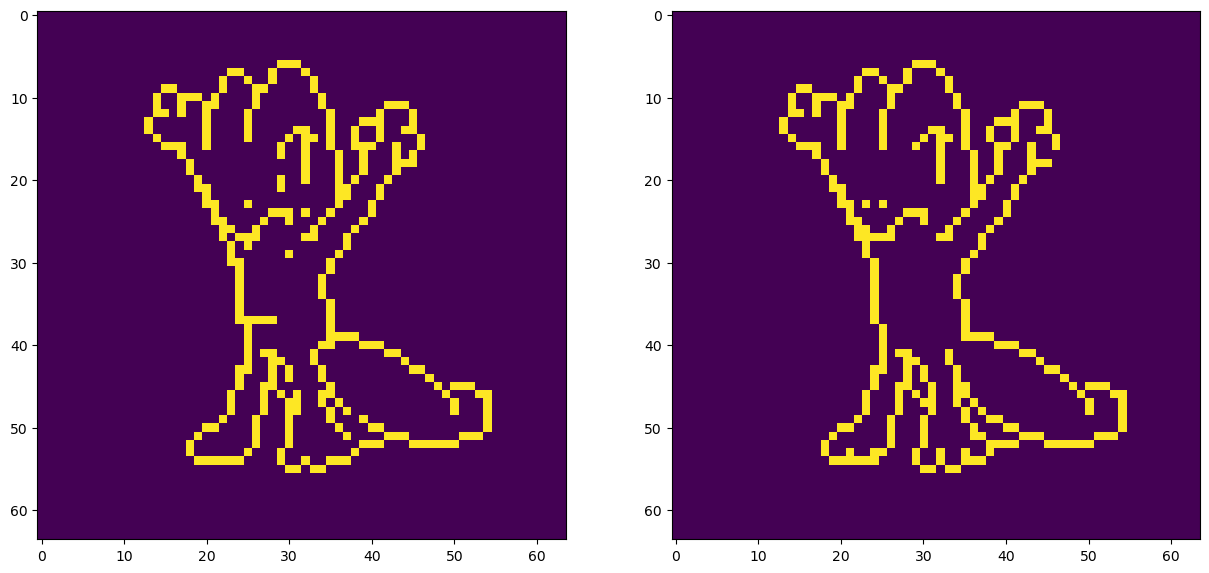

Epoch 11. Loss: 0.5382: 100%|██████████| 10/10 [00:00<00:00, 10.61it/s]


0.89608


Epoch 12. Loss: 0.3789: 100%|██████████| 10/10 [00:00<00:00, 10.71it/s]


0.84160


Epoch 13. Loss: 0.3752: 100%|██████████| 10/10 [00:01<00:00,  8.78it/s]


0.81438


Epoch 14. Loss: 0.3233: 100%|██████████| 10/10 [00:00<00:00, 10.26it/s]


1.05842


Epoch 15. Loss: 0.4029: 100%|██████████| 10/10 [00:00<00:00, 10.14it/s]


0.89575


Epoch 16. Loss: 0.3506: 100%|██████████| 10/10 [00:00<00:00, 11.09it/s]


0.84151


Epoch 17. Loss: 0.2975: 100%|██████████| 10/10 [00:00<00:00, 11.16it/s]


0.84221


Epoch 18. Loss: 0.3114: 100%|██████████| 10/10 [00:01<00:00,  9.69it/s]


0.78746


Epoch 19. Loss: 0.2860: 100%|██████████| 10/10 [00:00<00:00, 10.04it/s]


1.00413


Epoch 20. Loss: 0.3001: 100%|██████████| 10/10 [00:00<00:00, 10.50it/s]


0.78746


Epoch 21. Loss: 0.1946: 100%|██████████| 10/10 [00:00<00:00, 10.02it/s]


0.89590


Epoch 22. Loss: 0.2289: 100%|██████████| 10/10 [00:01<00:00,  8.84it/s]


0.84148


Epoch 23. Loss: 0.2663: 100%|██████████| 10/10 [00:00<00:00, 10.77it/s]


0.73318 *


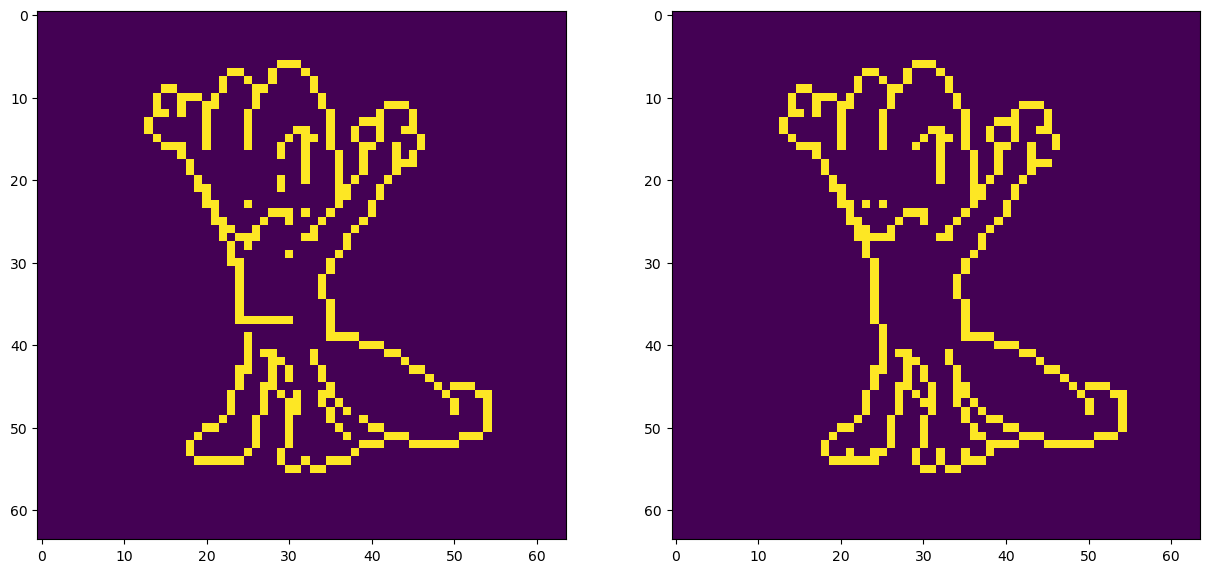

Epoch 24. Loss: 0.3017: 100%|██████████| 10/10 [00:01<00:00,  9.21it/s]


0.86861


Epoch 25. Loss: 0.3065: 100%|██████████| 10/10 [00:01<00:00,  9.46it/s]


0.78734


Epoch 26. Loss: 0.2072: 100%|██████████| 10/10 [00:01<00:00,  8.56it/s]


0.76040


Epoch 27. Loss: 0.1817: 100%|██████████| 10/10 [00:01<00:00,  9.26it/s]


1.00438


Epoch 28. Loss: 0.2653: 100%|██████████| 10/10 [00:01<00:00,  9.38it/s]


0.97703


Epoch 29. Loss: 0.2714: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


0.70631 *


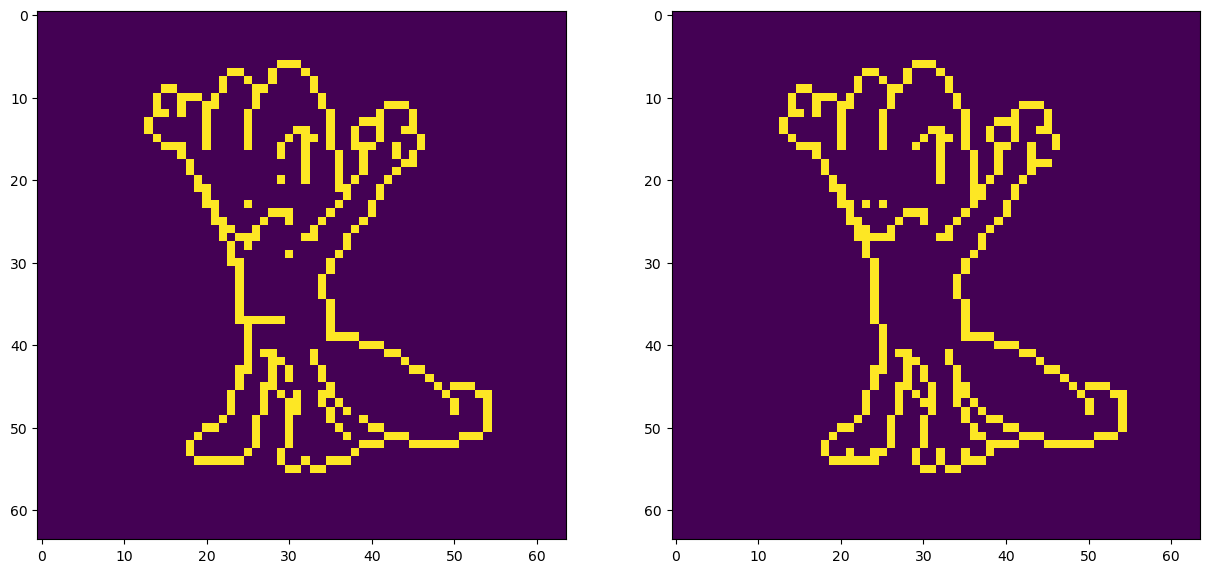

Epoch 30. Loss: 0.1467: 100%|██████████| 10/10 [00:01<00:00,  9.34it/s]


0.76026


Epoch 31. Loss: 0.2771: 100%|██████████| 10/10 [00:00<00:00, 10.52it/s]


0.86867


Epoch 32. Loss: 0.2290: 100%|██████████| 10/10 [00:01<00:00,  9.60it/s]


0.70612 *


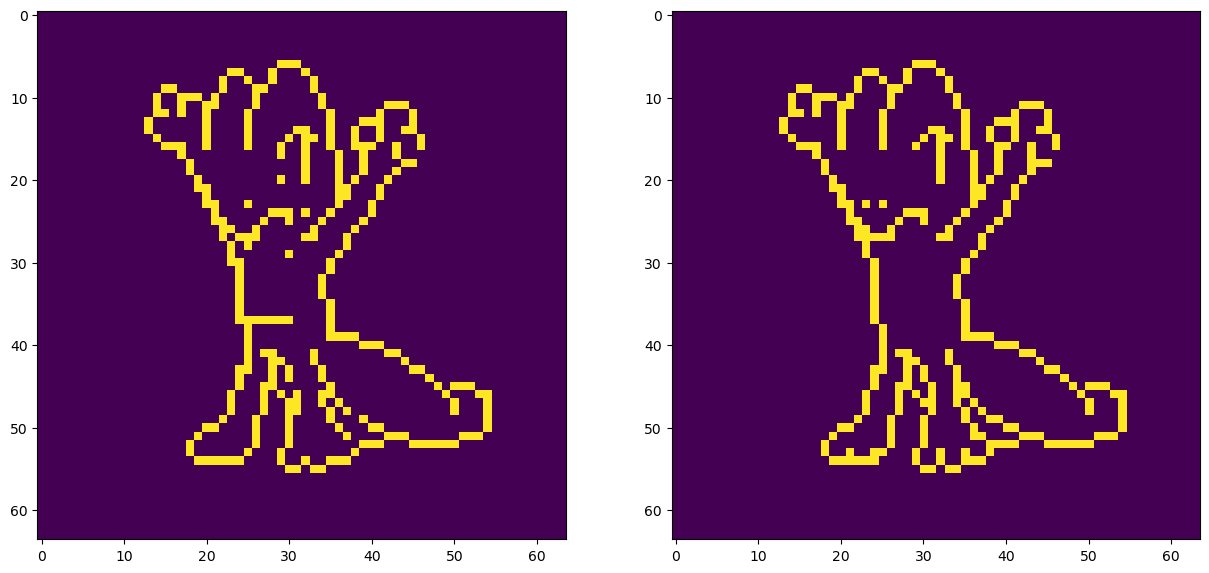

Epoch 33. Loss: 0.2565: 100%|██████████| 10/10 [00:01<00:00,  8.90it/s]


0.67906 *


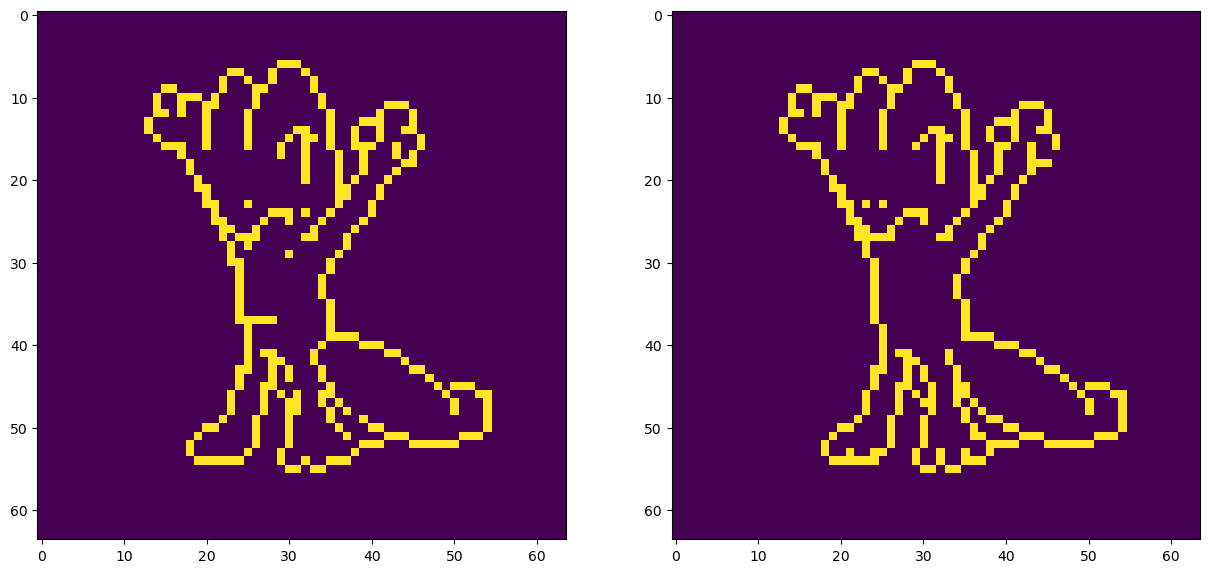

Epoch 34. Loss: 0.2323: 100%|██████████| 10/10 [00:01<00:00,  9.33it/s]


0.89571


Epoch 35. Loss: 0.1729: 100%|██████████| 10/10 [00:01<00:00,  9.76it/s]


0.89572


Epoch 36. Loss: 0.1553: 100%|██████████| 10/10 [00:00<00:00, 10.83it/s]


0.81442


Epoch 37. Loss: 0.2199: 100%|██████████| 10/10 [00:01<00:00,  9.15it/s]


0.78726


Epoch 38. Loss: 0.2668: 100%|██████████| 10/10 [00:00<00:00, 10.33it/s]


0.92284


Epoch 39. Loss: 0.1329: 100%|██████████| 10/10 [00:00<00:00, 10.32it/s]


0.92281


Epoch 40. Loss: 0.1307: 100%|██████████| 10/10 [00:01<00:00,  9.59it/s]


0.84151


Epoch 41. Loss: 0.2429: 100%|██████████| 10/10 [00:01<00:00,  8.81it/s]


0.81437


Epoch 42. Loss: 0.2505: 100%|██████████| 10/10 [00:01<00:00,  9.59it/s]


0.89571


Epoch 43. Loss: 0.1986: 100%|██████████| 10/10 [00:00<00:00, 10.69it/s]


0.95008


Epoch 44. Loss: 0.1494: 100%|██████████| 10/10 [00:01<00:00,  9.54it/s]


1.03139


Epoch 45. Loss: 0.2533: 100%|██████████| 10/10 [00:01<00:00,  8.89it/s]


0.84160


Epoch 46. Loss: 0.1791: 100%|██████████| 10/10 [00:01<00:00,  9.71it/s]


1.00438


Epoch 47. Loss: 0.1511: 100%|██████████| 10/10 [00:01<00:00,  9.84it/s]


0.76017


Epoch 48. Loss: 0.2468: 100%|██████████| 10/10 [00:00<00:00, 10.23it/s]


0.92281


Epoch 49. Loss: 0.2687: 100%|██████████| 10/10 [00:01<00:00,  8.45it/s]


0.81453


Epoch 50. Loss: 0.1143: 100%|██████████| 10/10 [00:00<00:00, 10.33it/s]


0.92281


Epoch 51. Loss: 0.1708: 100%|██████████| 10/10 [00:00<00:00, 10.25it/s]


0.97711


Epoch 52. Loss: 0.2422: 100%|██████████| 10/10 [00:01<00:00,  9.94it/s]


0.89578


Epoch 53. Loss: 0.2680: 100%|██████████| 10/10 [00:00<00:00, 10.06it/s]


0.86875


Epoch 54. Loss: 0.1081: 100%|██████████| 10/10 [00:01<00:00,  8.50it/s]


0.94993


Epoch 55. Loss: 0.2377: 100%|██████████| 10/10 [00:01<00:00,  9.23it/s]


0.84151


Epoch 56. Loss: 0.2431: 100%|██████████| 10/10 [00:01<00:00,  9.06it/s]


0.84151


Epoch 57. Loss: 0.1873: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


0.81442


Epoch 58. Loss: 0.2563: 100%|██████████| 10/10 [00:01<00:00,  8.82it/s]


1.00416


Epoch 59. Loss: 0.2580: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


0.89571


Epoch 60. Loss: 0.1703: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


0.78734


Epoch 61. Loss: 0.1910: 100%|██████████| 10/10 [00:01<00:00,  9.63it/s]


0.94997


Epoch 62. Loss: 0.2654: 100%|██████████| 10/10 [00:01<00:00,  9.14it/s]

0.86860
Patience ended.


<All keys matched successfully>

In [8]:
model.train()

bce_loss = nn.BCELoss()
loss_fn = lambda output, target: bce_loss(output, target) + 3 * ssim_loss(output, target)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3)

epochs = 500
patience = 30

best_loss = torch.inf
best_model = copy.deepcopy(model.state_dict())
pat_count = 0

val_losses = []

for i in range(epochs):
    model.train()

    # Train
    pbar = tqdm(range(10))
    for j in pbar:
        for data in train_dl:
            optimizer.zero_grad()
            
            data = data.to(device)
            data = torch.stack([train_transform1(x) for x in data])
            im = data[:, :-1]
            lb = data[:, [-1]]

            im = torch.stack([train_transform2(x) for x in im])

            out = model(im)
            loss = loss_fn(out, lb).mean()
            pbar.set_description(f"Epoch {i}. Loss: {loss:.4f}", refresh=False)
            
            loss.backward()
            optimizer.step()
    
    with torch.no_grad():
        model.eval()

        data = next(iter(val_dl)).to(device)
        im = data[:, :-1]
        lb = data[:, [-1]]

        out = model(im)
        loss = loss_fn(out, lb).mean()

        if loss <= best_loss:
            best_loss = loss
            best_model = copy.deepcopy(model.state_dict())
            pat_count = 0
            print(f'{loss:.5f} *')

            fig, axes = plt.subplots(1, 2, figsize=(15, 10))
            axes[0].imshow(out[0].permute(1, 2, 0).numpy(), vmin=0, vmax=1)
            axes[1].imshow(lb[0].permute(1, 2, 0).numpy(), vmin=0, vmax=1)
            plt.show()
        else:
            print(f'{loss:.5f}')

        val_losses.append(loss)

        pat_count = pat_count + 1
        if pat_count == patience:
            print("Patience ended.")
            break

model.load_state_dict(best_model)

In [9]:
# save model with jit
model.eval()
model = torch.jit.script(model)
model.save("contour_model.pt")

In [13]:
src = "dataset/emerald/"
dst = "dataset/emerald_cont/"

os.makedirs(dst, exist_ok=True)

imgs = os.listdir(src)
if "back" in imgs:
    imgs.remove("back")

for i in imgs:

    toTensor = transforms.ToTensor()
    img = Image.open(src + i)
    img = toTensor(img.convert("RGBA"))
    
    alpha = img[[3]]
    img = img[[0,1,2]] * alpha
    img += 1 - alpha

    out = model(img[None, ...])[0]

    toPIL = transforms.ToPILImage(mode="L")
    img = toPIL(out)
    img.convert("RGB").save(dst + i)
